# About the dataset
This contains data of news headlines published over a period of 15 years. From the reputable Australian news source ABC (Australian Broadcasting Corp.)
Site: http://www.abc.net.au/
Prepared by Rohit Kulkarni


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/franciscadias/data/master/abcnews-date-text.csv",error_bad_lines=False,usecols =["headline_text"])
data.head()

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082168 entries, 0 to 1082167
Data columns (total 1 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   headline_text  1082168 non-null  object
dtypes: object(1)
memory usage: 8.3+ MB


# Deleting dupliate headlines(if any)

In [5]:
data[data['headline_text'].duplicated(keep=False)].sort_values('headline_text').head(8)

,headline_text
116304,10 killed in pakistan bus crash
57973,10 killed in pakistan bus crash
676588,110 with barry nicholls
673123,110 with barry nicholls
748887,110 with barry nicholls
912413,110 with barry nicholls
898238,110 with barry nicholls episode 15
827356,110 with barry nicholls episode 15


In [6]:
data = data.drop_duplicates('headline_text')

# NLP 

In [9]:
# preprocessing
# import the necessary libraries
import string
import nltk
import re
def text_lowercase(text):
    return text.lower()
# Remove numbers
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result
# remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
# remove whitespace from text
def remove_whitespace(text):
    return  " ".join(text.split())
# remove stopwords
def remove_stopwords(text):
    stopword_list = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return ' '.join([token for token in tokens if token not in stopword_list])
# stemming
def stem_text(text):
    ps = nltk.PorterStemmer()
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return ' '.join([ps.stem(token) for token in tokens])
# lemmatization
def lemmatize_text(text):
    wnl = nltk.WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return ' '.join([wnl.lemmatize(token) for token in tokens])
# remove special characters
def remove_special_characters(text):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
# remove extra newlines
def remove_extra_newlines(text):
    pattern=r'[\r|\n|\r]+'
    text=re.sub(pattern,' ',text)
    return text

# apply all the functions to the text
def preprocess(corpus):
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        doc = text_lowercase(doc)
        doc = remove_numbers(doc)
        doc = remove_punctuation(doc)
        doc = remove_whitespace(doc)
        doc = remove_special_characters(doc)
        doc = remove_extra_newlines(doc)
        doc = lemmatize_text(doc)
        doc = stem_text(doc)
        doc = remove_stopwords(doc)
        normalized_corpus.append(doc)
    return normalized_corpus

In [19]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

taking 10,000 headlines because of less compute capability

In [51]:
data2=preprocess(data['headline_text'][0:10000])

In [52]:
data2

['aba decid commun broadcast licenc',
 'act fire wit must awar defam',
 'g call infrastructur protect summit',
 'air nz staff aust strike pay rise',
 'air nz strike affect australian travel',
 'ambiti olsson win tripl jump',
 'antic delight record break barca',
 'aussi qualifi stosur wast four memphi match',
 'aust address un secur council iraq',
 'australia lock war timet opp',
 'australia contribut million aid iraq',
 'barca take record robson celebr birthday',
 'bathhous plan move ahead',
 'big hope launceston cycl championship',
 'big plan boost paroo water suppli',
 'blizzard buri unit state bill',
 'brigadi dismiss report troop harass',
 'british combat troop arriv daili kuwait',
 'bryant lead laker doubl overtim win',
 'bushfir victim urg see centrelink',
 'busi prepar terrorist attack',
 'calleri aveng final defeat elimin massu',
 'call ethanol blend fuel go ahead',
 'carew freak goal leaf rom ruin',
 'cemeteri miss fund',
 'code conduct toughen organ donat regul',
 'commonweal

# Bag of words

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data2)
X.toarray() 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# K-means clustering

# Elbow method to select number of clusters
This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified. Percentage of variance explained is the ratio of the between-group variance to the total variance, also known as an F-test. A slight variation of this method plots the curvature of the within group variance.
# Basically, number of clusters = the x-axis value of the point that is the corner of the "elbow"(the plot looks often looks like an elbow)

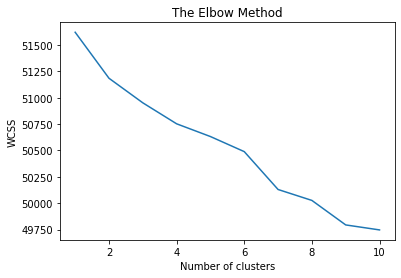

In [54]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

As more than one elbows have been generated, I will have to select right amount of clusters by trial and error. So, I will showcase the results of different amount of clusters to find out the right amount of clusters.

# we see elbow at 6, 7, 8 and 9 it is the best possible range of cluster to form

# 6 Clusters

In [58]:
kmeans = KMeans(n_clusters = 6, n_init = 20) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(X)
# We look at 3 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(data2[word] for word in centroid))

0 : man accus plot shoot parliament, claim u ha secur un vote major medium, call increas fish catch monitor, alston seiz glow telstra report, govt open new area oil explor, irish presid toast st pat day melbourn, water safeti skill workshop held school, u stock set open flat, sherpa plan world highest cyber cafe byo oxygen, thoma surg win, hope peopl deadli peanut allergi, one dead two injur victorian abattoir, two woman found dead unit, yacht lose mast trawler incid, u plane shot baghdad sabri, mani qld shire still drought declar despit rain, enriqu sever week coach, anti war ralli ricochet across world, australia withdraw bougainvil peac monitor, dragila set new indoor pole vault world mark, freeman medium launch end shambl, secur gippsland raaf base review, manhunt shoot adelaid, dalbi award tender desalin plant, wa polic win extradit murder suspect
1 : geelong mayor account fraud earn year jail, uni given access qld biggest supercomput, polic investig suspici death new farm, man wh

# 7 Clusters

In [59]:
kmeans = KMeans(n_clusters = 7, n_init = 20) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(X)
# We look at 3 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(data2[word] for word in centroid))

0 : storm ravag south east qld, drought take toll insect, u poet rise war iraq, least kill itali car pileup, aussi dollar continu climb, men charg separ stab, drug accus moroccan accus kenyan rumour, irish presid toast st pat day melbourn, claim u ha secur un vote major medium, locust increas contain dri condit, britain ask turkey use airspac, pentagon list goal war, u send bomber deterr n korea, lga call local road fund increas, man charg ormiston attack, thoma surg win, nz say peac monitor leav png, yacht lose mast trawler incid, secur gippsland raaf base review, woman critic hurt boonah cliff fall, transport compani face court cyanid, fed govt send wheat iraq, show go broadway actor say, warn take chin, plan acquir land portsea move one step
1 : geelong mayor account fraud earn year jail, polic investig suspici death new farm, man accus plot shoot parliament, claim u ha secur un vote major medium, call increas fish catch monitor, govt open new area oil explor, u send bomber deterr n

# 8 Clusters

In [60]:
kmeans = KMeans(n_clusters = 8, n_init = 20) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(X)
# We look at 3 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(data2[word] for word in centroid))

0 : storm ravag south east qld, drought take toll insect, least kill itali car pileup, u poet rise war iraq, aussi dollar continu climb, men charg separ stab, drug accus moroccan accus kenyan rumour, locust increas contain dri condit, irish presid toast st pat day melbourn, britain ask turkey use airspac, pentagon list goal war, lga call local road fund increas, u send bomber deterr n korea, claim u ha secur un vote major medium, thoma surg win, man charg ormiston attack, yacht lose mast trawler incid, nz say peac monitor leav png, warn take chin, fed govt send wheat iraq, secur gippsland raaf base review, woman critic hurt boonah cliff fall, show go broadway actor say, afl examin warn anti dope find, mysteri ill claim life
1 : claim u ha secur un vote major medium, u plane shot baghdad sabri, man accus plot shoot parliament, alston seiz glow telstra report, call increas fish catch monitor, japanes tourist clip wing skydiv mishap, fish nt genet tag, yacht lose mast trawler incid, least

# 9 Clusters

In [61]:
kmeans = KMeans(n_clusters = 9, n_init = 20) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(X)
# We look at 3 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(data2[word] for word in centroid))

0 : shire look share health resourc, runaway bu smash home car, bush assassin saddam report, loss pittman wake call freeman, new rural doctor train facil establish, black name best nbl, u poet rise war iraq, u send bomber deterr n korea, australia withdraw bougainvil peac monitor, u stock set open flat, civilian injuri report baghdad, farmer continu iraq trade, athen risk turn game disast ioc, qld govt say new hospit schedul, search better life pay, direct anger govt soldier crean urg, pont pay tribut hussain, aba say anoth wollongong commun radio, mani qld shire still drought declar despit rain, iraq agre principl destroy missil, pollock get chop, politician spat show support, carr happi accept green prefer, two kill wa motorbik collis, bin laden escap u oper taliban
1 : u poet rise war iraq, man accus plot shoot parliament, claim u ha secur un vote major medium, irish presid toast st pat day melbourn, govt open new area oil explor, water safeti skill workshop held school, u send bomb